In [1]:
FILES_PATH = '/data/in/files/'


In [2]:
# import libraries
import os
import sys
import re

# get files not ending with manifest
script_files = [f for f in os.listdir(FILES_PATH) if re.match(r'^[0-9]+_.+$', f) and not f.endswith('.manifest')]

# create new name for files
rename_dict = {f: re.sub(r'^[0-9]+_(.*)', '\\1', f) for f in script_files}

# rename files
for old, new in rename_dict.items():
    os.rename(f'{FILES_PATH}{old}', f'{FILES_PATH}{new}')
    print(f'In {FILES_PATH}, {old} renamed to {new}')
    
# add FILES_PATH to sys.path
sys.path.append(FILES_PATH)


In [3]:
import json

import numpy as np
import pandas as pd
from tqdm import tqdm

from fasttext import FastText


In [4]:
mats = pd.read_csv("in/tables/MATERIALS_FOR_CLASSIFICATION_CLEAN.csv")
cats = pd.read_csv("in/tables/MATERIAL_CATEGORY_FOR_CLASSIFICATION.csv")

df = pd.merge(mats,cats,on=["MATERIAL_ODS_ID","SHOP"])

def create_category_dict(df):
    return df.groupby("CATEGORY_ID").CATEGORY_PATH.unique().to_dict()
category_dict = create_category_dict(df)

# should be applied after category_decoder_dict
df = df[~df.MATERIAL_ID.duplicated()].reset_index(drop=True).copy()


### transformers embd

In [6]:
contx_embd = pd.read_csv("in/tables/SENT_EMBD_ROBERTA.csv", usecols=["MATERIAL_ID"])

In [7]:
to_exclude = np.setdiff1d(contx_embd.index,contx_embd.drop_duplicates().index)+1

In [26]:
contx_embd = pd.read_csv("in/tables/SENT_EMBD_ROBERTA.csv", skiprows=to_exclude)

In [27]:
contx_embd = contx_embd.drop_duplicates("MATERIAL_ID").copy()

In [28]:
contx_embd = contx_embd[~contx_embd.MATERIAL_ID.str.contains("M")].copy()
contx_embd.MATERIAL_ID = contx_embd.MATERIAL_ID.astype(int)

In [29]:
contx_embd.MATERIAL_ID = contx_embd.MATERIAL_ID.astype(int)

In [30]:
df = pd.merge(df,contx_embd, on=["MATERIAL_ID"])

### image embd

In [7]:
image_embd_mats = pd.read_csv("in/tables/IMAGE_EMBD.csv", usecols=["MATERIAL_ID"])

In [8]:
image_indexes = image_embd_mats[image_embd_mats.MATERIAL_ID.isin(df.MATERIAL_ID.values)].index

In [9]:
to_exclude = np.setdiff1d(image_embd_mats.index, image_indexes)+1

df_iteration = pd.read_csv("in/tables/IMAGE_EMBD.csv",
                          skiprows=to_exclude)

In [10]:
df = pd.merge(df,df_iteration, on=["MATERIAL_ID"])

In [11]:
del mats, cats, df_iteration, image_embd_mats

In [12]:
columns= ["MATERIAL_ID","CATEGORY_PATH","CATEGORY_ID","IMAGE_EMBD"]
df[columns].to_csv("preprocess_embd.csv", index=False)

In [31]:
def clean_embd_from_pandas(df_embds,column):
    clean_embeddings = []
    for i in df_embds[column].values:
        clean_embedding = []
        i = (i
           .replace("[", "")
           .replace ("]", "")
           .replace ("\n", "")
           .replace (",", "")
           .split())
        for j in i:
            clean_embedding.append(float(j))
        clean_embeddings.append(np.array(clean_embedding))
    df_embds[column] = clean_embeddings

In [35]:
# clean_embd_from_pandas(df,"MEAN_1_y")
clean_embd_from_pandas(df,"SUM_4_y")
# clean_embd_from_pandas(df,"CONCAT_4")

# fasttext model

In [6]:
from sh import gunzip

# unzip fastext models
gunzip(f"{FILES_PATH}"+"cc.cs.300.bin.gz")

In [5]:
fasttext = FastText.load_model(f"{FILES_PATH}"+"cc.cs.300.bin")



from sklearn.preprocessing import FunctionTransformer

def encode_dataframe(X):
    return np.array([fasttext.get_sentence_vector(i) for i in X])

transformer = FunctionTransformer(encode_dataframe)

# preprocessing training data

In [6]:
df = df.drop_duplicates("MATERIAL_ID").reset_index().copy()

In [7]:
# test_categories = df.CATEGORY_ID.value_counts().reset_index().query("CATEGORY_ID > 20")["index"].values
# df = df.query("CATEGORY_ID in @test_categories").copy()

def remove_too_small_categories(df, how_many=20):
    """
    Remove all categories small than @how_many, 
    because it is unsufficient to add them to classification.
    These categories need to be evaluated in final testing.
    """
    too_small_cats = df.CATEGORY_ID.value_counts().reset_index().query("CATEGORY_ID<@how_many")["index"].unique()
    indices = df[df.CATEGORY_ID.isin(too_small_cats)].index
    small_cat_df = df.iloc[indices].copy()
    print(f"Len of df before: {df.shape[0]}")
    df.drop(indices, inplace=True)
    print(f"Len of df after: {df.shape[0]}")
    return small_cat_df

too_small_categories_df = remove_too_small_categories(df)


Len of df before: 242110
Len of df after: 240998


In [8]:
from sklearn.model_selection import train_test_split

def create_datasets(df, stratify_by="CATEGORY_ID",make_valid=None, random_state=1):
    """
    Create train/test, possibly also validation dataset.
    If make_valid=True, then returns df,list(df,df)
    """
    train, test = train_test_split(df.reset_index(drop=True), 
                                   stratify=df[stratify_by],
                                   test_size=0.3, 
                                   random_state=random_state)
    if make_valid:
        test = train_test_split(test.reset_index(drop=True),
                                test_size=0.3,
                                random_state=random_state)
    
    return train, test

def over_sample(df, categories_smaller=100):
    """
    Oversample for really small categories
    """
    new_df = pd.DataFrame()
    # smaller categories
    small_categories = (df.CATEGORY_ID
                        .value_counts()
                        .reset_index()
                        .query("CATEGORY_ID < 100"))
    
    for _,cat_id, count in small_categories.itertuples():
        append_another = categories_smaller-count
        df_cat = df.query("CATEGORY_ID == @cat_id")
        new_df = new_df.append(df_cat.iloc[np.random.randint(df_cat.shape[0],size=append_another)])
    
    print(f"Appending {new_df.shape[0]} of new samples")
    return pd.concat([df,new_df])


# trees sample training

In [39]:
train_sample = train.groupby("CATEGORY_ID",group_keys=False).apply(lambda x: x.sample(frac=0.1))

In [24]:
import joblib

In [44]:
joblib.dump(pipeline[-1],"RF_3.pkl")

['RF_3.pkl']

In [9]:
from sklearn.decomposition import PCA

In [10]:
train_vector = [fasttext.get_sentence_vector(i) for i in train["NAME_BRIEF"]]
pca = PCA(0.34)
pca_features = pca.fit_transform(train_vector)

In [11]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

algorithms = {"RF":RandomForestClassifier(),
             "XGB":XGBClassifier()}
METHOD="RF"

model = algorithms[METHOD]
from sklearn.preprocessing import LabelEncoder

X = pca_features
y_raw = train.CATEGORY_ID

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y_raw)

model.fit(X,y)


RandomForestClassifier()

In [13]:
test_vector = [fasttext.get_sentence_vector(i) for i in test["NAME_BRIEF"]]
pca_features = pca.fit_transform(test_vector)

In [14]:
predicitons = model.predict(pca_features)

In [17]:
decoded_prediction = decode_predictions(predicitons)
    
score = precision_recall_fscore_support(test.CATEGORY_ID, decoded_prediction[0], average="weighted")

/home/default/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [18]:
score

(0.4256630879174642, 0.3519225449515906, 0.36053210105940436, None)

In [180]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

algorithms = {"RF":RandomForestClassifier(),
             "XGB":XGBClassifier()}
METHOD="RF"
pipeline = Pipeline([("fasttext",transformer),
                     (f"{METHOD}", algorithms[METHOD])])

from sklearn.preprocessing import LabelEncoder

X = train_sample["NAME_BRIEF"]
y_raw = train_sample.CATEGORY_ID

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y_raw)

pipeline.fit(X,y)


KeyboardInterrupt: 

# Ensemble trees

In [120]:
predictions = []
for i in range(1,4):
    model = joblib.load(f"RF_{i}.pkl")
    pipeline = Pipeline([("fasttext",transformer),
                     ("RF",model)])
    
    predictions.append(pipeline.predict_proba(test["NAME_BRIEF"]))

In [166]:
preds = []
for i in range(len(predictions[0])):
    preds.append(np.max([predictions[0][i],predictions[1][i],predictions[2][i]],axis=0))

In [167]:
test = pd.read_csv("out/tables/CATEGORIZER_TEST_L2_LX.csv")

In [168]:
y_pred = np.argmax(preds,axis=1)

In [169]:
decoded_prediction = decode_predictions(y_pred)
    
score = precision_recall_fscore_support(test.CATEGORY_ID, decoded_prediction[0], average="weighted")

/home/default/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [170]:
score

(0.8524559419305164, 0.797551867219917, 0.7846755557187061, None)

In [16]:
def decode_predictions(predictions, 
                       category_dict=category_dict, 
                       label_encoder=label_encoder):
    category_id = label_encoder.inverse_transform(predictions)
    categories = [category_dict[i] for i in category_id]
    category_name = [i[0] for i in categories]
    other_names = [None if len(i) == 1
                           else i[1:] for i in categories]
    
    return category_id, category_name, other_names

from sklearn.metrics import precision_recall_fscore_support
def evaluate_results(pipeline, test, category_column, text_column):
    df = test.copy()
    y_true = df[category_column]
    y_pred = pipeline.predict(df[text_column])
    
    
    decoded_prediction = decode_predictions(y_pred)
    
    score = precision_recall_fscore_support(y_true, decoded_prediction[0], average="weighted")
    df_new = pd.concat([df,pd.DataFrame(decoded_prediction,
                                        index=["PRED_CATEGORY_ID","PREDICTIONS","ALTERNATIVE_NAMES"],
                                        columns=df.index).T], 
                       axis=1)
    df_new["SAME"] = df_new.eval("PRED_CATEGORY_ID == CATEGORY_ID")
    return score[:3], df_new[["MATERIAL_ID","SHOP","CATEGORY_ID",
                          "PRED_CATEGORY_ID","CATEGORY_PATH",
                          "PREDICTIONS","ALTERNATIVE_NAMES","SAME"]]

In [54]:
scores, pred_df = evaluate_results(pipeline,
                                   test,
                                   "CATEGORY_ID",
                                   "NAME_BRIEF")

/home/default/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
pred_df["MODEL"] = METHOD + MODALITY + PRE
pred_df.to_csv("out/tables/PREDICTIONS.csv",index=False)

results = [METHOD] + [MODALITY+PRE] + [i for i in scores]
results_df = pd.DataFrame(results,index=["ALGORITHM","MODALITIES","P","R","F1"]).T
results_df["MODEL"] = METHOD + MODALITY + PRE
results_df.to_csv("out/tables/RESULTS.csv",index=False)

import joblib
joblib.dump(pipeline, 'out/files/ROMAN_DP_MODEL.pkl')


# trénink

In [13]:
def generate_column_from_sources(df, column, split=False,position=None):
    df = df[df[column].notna()].copy()
    if split:
        assert position != None
        df["train_column"] = df[column].apply(lambda x: x.split(" ; ")[position])
    else:
        df["train_column"] = df[column]
    features = encode_dataframe(df["train_column"])
    df["feature_vector"] = [i for i in features]
    return df

In [14]:
df_train = generate_column_from_sources(df,"NAME_BRIEF_DESCRIPTION")

In [ ]:
np.load("label_error.npy") = np.load("label_error.npy")

In [ ]:
# filter label errors
df_train = df_train[~df_train.MATERIAL_ID.isin(df_train.iloc[label_error_indices_prob].MATERIAL_ID.values)]

In [43]:
train, test = create_datasets(df_train)
train = over_sample(train)

Appending 8814 of new samples


In [44]:
# df_train.to_csv("df_no_error.csv",index=False)

In [68]:
# concatenating text sources vectors
train_vector = np.concatenate([train_name,train_desc,train_brief],axis=1)
test_vector = np.concatenate([test_name,test_desc,test_brief],axis=1)

In [20]:
def preprocess_embds(train,test,column, dimension):
    "embeddings needs to be proccessed"
    train_vector = np.concatenate(train[column].values, dtype=np.float32).reshape(-1,dimension)
    test_vector = np.concatenate(test[column].values, dtype=np.float32).reshape(-1,dimension)
    return train_vector, test_vector

In [49]:
train_vector, test_vector = preprocess_embds(train,test,
                                             column="SUM_4_y",dimension=768)

In [45]:
from sklearn.preprocessing import LabelEncoder
X = np.concatenate(train.feature_vector.values).reshape(-1,300)
y_raw = train.CATEGORY_ID

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y_raw)

X_test = np.concatenate(test.feature_vector.values).reshape(-1,300)
y_raw_test = test.CATEGORY_ID
y_test = label_encoder.transform(y_raw_test)

In [44]:
pip install tensorflow-cpu

     |████████████████████████████████| 179.9 MB 5.8 kB/s              
     |████████████████████████████████| 42 kB 3.2 MB/s              
     |████████████████████████████████| 65 kB 11.3 MB/s             
     |████████████████████████████████| 2.1 MB 110.0 MB/s            
     |████████████████████████████████| 4.1 MB 105.5 MB/s            
     |████████████████████████████████| 5.8 MB 116.4 MB/s            
     |████████████████████████████████| 57 kB 14.7 MB/s             
     |████████████████████████████████| 126 kB 135.5 MB/s            
     |████████████████████████████████| 1.3 MB 114.9 MB/s            
  Preparing metadata (setup.py) ... done
     |████████████████████████████████| 463 kB 100.4 MB/s            
     |████████████████████████████████| 13.3 MB 95.8 MB/s            
     |████████████████████████████████| 4.9 MB 87.6 MB/s            
     |████████████████████████████████| 97 kB 18.2 MB/s             
     |████████████████████████████████| 155 kB 132.5

In [17]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Activation, Dropout, Concatenate, Flatten, Input
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import precision_recall_fscore_support
import tensorflow as tf

In [47]:
model_dict = {}
for h_layers in [1, 2]:
    for h_units in [128, 256, 512]:
        if h_layers==2 and h_units in [32,64]:
            continue
        print(f"fasttext_NB_{h_layers}_{h_units}")   
        
        n_of_layers = h_layers
        model = tf.keras.Sequential([
            tf.keras.layers.Flatten()
        ])
        
        while n_of_layers!=0 :
            model.add(tf.keras.layers.Dense(h_units, activation='relu'))
            n_of_layers-=1
        
        model.add(tf.keras.layers.Dense(train.CATEGORY_ID.unique().shape[0]))
        
        model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
        
        # simple early stopping
        es = EarlyStopping(monitor='val_loss',mode='min', verbose=1,min_delta=0.005,patience=1)
        
        history = model.fit(X, y, epochs=20, batch_size=200, validation_data=(X_test, y_test), callbacks=[es],verbose=1)
        # history = model.fit(X, y, epochs=20,validation_data=(test_vector, y_test),verbose=1)
        predictions = model.predict(X_test)
        predictions = np.argmax(predictions,axis=1)
        
        fscore = precision_recall_fscore_support(y_test, predictions,average="weighted")[2]
        print(fscore)
        model_dict[f"fasttext_NB_{h_layers}_{h_units}"] = [history, fscore, model.count_params()]

fasttext_NB_1_512
Epoch 1/20
880/880 [==============================] - 10s 12ms/step - loss: 2.5728 - accuracy: 0.4967 - val_loss: 1.3536 - val_accuracy: 0.6823
Epoch 2/20
880/880 [==============================] - 10s 11ms/step - loss: 1.1739 - accuracy: 0.7108 - val_loss: 0.9192 - val_accuracy: 0.7753
Epoch 3/20
880/880 [==============================] - 10s 11ms/step - loss: 0.8624 - accuracy: 0.7834 - val_loss: 0.7554 - val_accuracy: 0.8138
Epoch 4/20
880/880 [==============================] - 10s 12ms/step - loss: 0.7167 - accuracy: 0.8181 - val_loss: 0.6659 - val_accuracy: 0.8327
Epoch 5/20
880/880 [==============================] - 10s 12ms/step - loss: 0.6262 - accuracy: 0.8399 - val_loss: 0.6017 - val_accuracy: 0.8468
Epoch 6/20
880/880 [==============================] - 10s 12ms/step - loss: 0.5602 - accuracy: 0.8566 - val_loss: 0.5628 - val_accuracy: 0.8532
Epoch 7/20
880/880 [==============================] - 10s 11ms/step - loss: 0.5100 - accuracy: 0.8678 - val_loss: 0.51

In [ ]:
fscore_list = []
for k,v in model_dict.items():
    fscore_list.append(np.round(v[1],3))
    [print(i) for i in fscore_list]

In [48]:
checkpoint = ModelCheckpoint('model.h5', verbose=1, monitor='val_loss',save_best_only=True, mode='auto')

In [49]:
history = model.fit(X, y, epochs=20, batch_size=200,validation_data=(X_test, y_test), callbacks=[checkpoint],verbose=1)

Epoch 1/20
880/880 [==============================] - ETA: 0s - loss: 0.2198 - accuracy: 0.9419
Epoch 00001: val_loss improved from inf to 0.32659, saving model to model.h5
880/880 [==============================] - 10s 12ms/step - loss: 0.2198 - accuracy: 0.9419 - val_loss: 0.3266 - val_accuracy: 0.9178
Epoch 2/20
876/880 [============================>.] - ETA: 0s - loss: 0.2104 - accuracy: 0.9443
Epoch 00002: val_loss improved from 0.32659 to 0.32207, saving model to model.h5
880/880 [==============================] - 10s 12ms/step - loss: 0.2104 - accuracy: 0.9444 - val_loss: 0.3221 - val_accuracy: 0.9189
Epoch 3/20
873/880 [============================>.] - ETA: 0s - loss: 0.2015 - accuracy: 0.9463
Epoch 00003: val_loss improved from 0.32207 to 0.31495, saving model to model.h5
880/880 [==============================] - 10s 12ms/step - loss: 0.2012 - accuracy: 0.9464 - val_loss: 0.3149 - val_accuracy: 0.9211
Epoch 4/20
879/880 [============================>.] - ETA: 0s - loss: 0.19

In [50]:
predictions = model.predict(X_test)
predictions = np.argmax(predictions,axis=1)

fscore = precision_recall_fscore_support(y_test, predictions,average="weighted")[2]
print(fscore)

0.9342242907893378


In [56]:
test_copy = test.reset_index(drop=True).copy()

# top@5/@10

In [54]:
def top_n_accuracy(probabilities, n, y_test):
    topn = np.flip(np.argsort(probabilities, axis = 1), axis=1)[:,:n]

    y_true = np.array(y_test)
    return np.mean(np.array([1 if y_true[k] in topn[k] else 0 for k in range(len(topn))]))

In [55]:
top_n_accuracy(predictions, 5, y_test)

0.953792453875561

In [132]:
top_n_accuracy(cnn_predictions, 10, y_test)

0.9675161609124637

In [147]:
predictions = model.predict(test_vector)

In [40]:
np.save("text_pred.npy",predictions)

In [70]:
cnn_predictions = np.load("cnn_pred.npy")

In [148]:
predictions = cnn_predictions + predictions

In [150]:
topn = np.flip(np.argsort(predictions, axis = 1), axis=1)[:,:5]

In [186]:
y_true = np.array(y_test)
true_list = [1 if y_true[k] in topn[k] else 0 for k in range(len(topn))]

In [165]:
preds = []
for i in topn:
    pred = []
    for j in i:
        pred.append(label_encoder.inverse_transform([j]))
    preds.append(pred)

In [173]:
pred_path_list = []
for i in preds:
    pred_path = []
    for j in i:
        pred_path.append(" > ".join(category_dict[int(j)]))
    pred_path_list.append(pred_path)
    

In [182]:
test["top5_paths"] = pred_path_list

In [196]:
test[[True if i == 0 else False for i in true_list]].to_csv("top5_wrong.csv",index=False)

In [143]:
top_n_accuracy(predictions, 10, y_test)

0.9923205288142184

In [78]:
precision_recall_fscore_support(y_test, predictions,average="weighted")[2]

0.921739330982939

In [46]:
test["PRED_ID"] = label_encoder.inverse_transform(predictions)
pred_path_list = []
for i in test["PRED_ID"]:
    pred_path_list.append(" > ".join(category_dict[i]))
    
test["PRED_PATH"] = pred_path_list

test[["MATERIAL_ID","NAME_BRIEF",
      "NAME_DESCRIPTION","CATEGORY_ID",
      "PRED_ID","CATEGORY_PATH","PRED_PATH"]].to_csv("test_CNN_mlp.csv",index=False)

# Clean lab

In [55]:
pip install cleanlab

     |████████████████████████████████| 77 kB 12.7 MB/s            
Note: you may need to restart the kernel to use updated packages.


In [25]:
probability_model = tf.keras.Sequential([model, 
                                         tf.keras.layers.Softmax()])
probability_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [26]:
from sklearn.base import BaseEstimator
class MyModel(BaseEstimator): # Inherits sklearn base classifier
    def __init__(self, model):
        self.model = model
    def fit(self, X, y, sample_weight = None):
        self.model.fit(X,y)
    def predict(self, X):
        return self.model.predict(X)
    def predict_proba(self, X):
        return self.model.predict(X)
    def score(self, X, y, sample_weight = None):
        pass

In [27]:
test_model = MyModel(probability_model)

In [34]:
from cleanlab.latent_estimation import estimate_cv_predicted_probabilities

# Find the indices of label errors in 2 lines of code.

probabilities = estimate_cv_predicted_probabilities(
    np.concatenate(df_train.feature_vector.values).reshape(-1,300), 
    label_encoder.transform(df_train.CATEGORY_ID.values), 
    clf=test_model,
)

2022-01-08 18:49:04.108990: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ram://82d45d80-07d8-40cc-9ab5-827b60d73ff0/assets
6025/6025 [==============================] - 23s 4ms/step - loss: 0.2079 - accuracy: 0.9443
INFO:tensorflow:Assets written to: ram://74726068-a013-44ae-998a-1c09da730609/assets
6025/6025 [==============================] - 23s 4ms/step - loss: 0.2072 - accuracy: 0.9454
INFO:tensorflow:Assets written to: ram://c615e08c-db85-4afe-9591-25ba9ef8ff38/assets
6025/6025 [==============================] - 23s 4ms/step - loss: 0.2071 - accuracy: 0.9442
INFO:tensorflow:Assets written to: ram://b8bee221-aad5-4aa7-9edf-5cd9b74cdaa5/assets
6025/6025 [==============================] - 23s 4ms/step - loss: 0.2071 - accuracy: 0.9447
INFO:tensorflow:Assets written to: ram://b329d1e4-47e0-49ae-843d-f284edc73f4d/assets
6025/6025 [==============================] - 23s 4ms/step - loss: 0.2070 - accuracy: 0.9447


In [36]:
from cleanlab.pruning import get_noise_indices
label_error_indices_prob = get_noise_indices(
    s = label_encoder.transform(df_train.CATEGORY_ID.values), 
    psx = probabilities,
    prune_method="both",
    sorted_index_method='prob_given_label', # Orders label errors
)

In [37]:
df_train.iloc[label_error_indices_prob]

,index,MATERIAL_ID,MATERIAL_ODS_ID,SHOP,NAME,BRIEF,NAME_BRIEF,NAME_DESCRIPTION,NAME_BRIEF_DESCRIPTION,IS_MAIN,CATEGORY_ID,CATEGORY_PATH,CATEGORY_URL,VISIBLE,CATEGORY_NAME,train_column,feature_vector
235932,235932,100053135845,2218705850,MACZ,držák bednový US 90x70mm,držák bednový US 90×70mm\n,držák bedn ; držák bedn,držák bedn ; držák bedn,držák bedn držák bedn,t,4671463,Hobby a zahrada > Stavební materiál > Spojovac...,https://www.mall.cz/zavitove-tyce,t,Závitové tyče,držák bedn držák bedn,"[0.03572943, 0.013761615, 0.05322641, 0.014833..."
168704,168704,691103,7092088,MACZ,"GBA 18V 2,0Ah",NaN,gba ;,gba ;,gba,t,18412293,Hobby a zahrada > Aku nářadí > Aku program,https://www.mall.cz/aku-program,t,Aku program,gba,"[-0.0070488877, 0.007857528, -0.0048071016, -0..."
77061,77061,100019709901,940072111,MACZ,Těsnění 60x42x1mm,Těsnění 60×42×1mm\n,těsněn ; těsněn,těsněn ; těsněn,těsněn těsněn,t,19165480,"Hobby a zahrada > Ohřev vody, vytápění > Topid...",https://www.mall.cz/radiatory,t,Radiátory,těsněn těsněn,"[0.022997703, -0.020094737, -0.035796724, -0.0..."
151168,151168,100050373650,2080663653,MACZ,Chránič kabelů SignUS DH 2,…\n,chránič kabel sign ;,chránič kabel sign ;,chránič kabel sign,t,37425,"Hobby a zahrada > Ohřev vody, vytápění > Topid...",https://www.mall.cz/prislusenstvi-topidla,t,Příslušenství k topidlům,chránič kabel sign,"[0.009975115, 0.02095398, -0.013715243, -0.025..."
61354,61354,100053131049,2218701283,MACZ,ND matka křídlová,ND matka křídlová\n,matk křídl ; matk křídl,matk křídl ; matk křídl,matk křídl matk křídl,t,3772507,Hobby a zahrada > Stavební materiál > Spojovac...,https://www.mall.cz/matice,t,Matice,matk křídl matk křídl,"[-0.028289039, 0.01964222, -0.051437143, -0.07..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
153642,153642,100070379327,2563067392,MACZ,Osmocote Exact 12-14M 25kg 15-9-11+2MgO+TE,Osmocote Exact Standard 12–14M uvolňuje živiny...,osmocot exact ; osmocot exact standard uvolň ž...,osmocot exact ; osmocot exact standard uvolň ž...,osmocot exact osmocot exact standard uvolň živ...,t,9462,Hobby a zahrada > Zahradní a travní doplňky > ...,https://www.mall.cz/substraty,t,Zahradnické substráty,osmocot exact osmocot exact standard uvolň živ...,"[0.018194634, 0.013261504, -0.008259728, 0.002..."
241925,241925,100053124138,2218501872,MACZ,Skalice modrá - 500 g,Skalice modrá – síran měďnatý – se používá pro...,skalic modr ; skalic modr síran měďnat použív ...,skalic modr ; měďnat hnojiv určen doplňk výživ...,skalic modr skalic modr síran měďnat použív ho...,t,9462,Hobby a zahrada > Zahradní a travní doplňky > ...,https://www.mall.cz/substraty,t,Zahradnické substráty,skalic modr skalic modr síran měďnat použív ho...,"[0.0018271597, 0.023830907, -0.010452954, -0.0..."
29539,29539,100058198990,2347564770,MACZ,Hnojivo NG univerzální 1l,"Tekuté hnojivo je určeno k výživě ovoce, zelen...",hnojiv univerzáln ; tekut hnojiv určen výživ o...,hnojiv univerzáln ; tekut hnojiv určen výživ o...,hnojiv univerzáln tekut hnojiv určen výživ ovo...,t,9462,Hobby a zahrada > Zahradní a travní doplňky > ...,https://www.mall.cz/substraty,t,Zahradnické substráty,hnojiv univerzáln tekut hnojiv určen výživ ovo...,"[0.032500856, 0.021207426, 0.021358028, -0.002..."
142670,142670,100057388110,2321282394,MACZ,"SFMCD721D2K-QW příklepová aku vrtačka, 2x Li-I...","Stanley SFMCD721D2K-QW příklepová aku vrtačka,...",příklep aku vrtačk ion bateri ; stanle příklep...,příklep aku vrtačk ion bateri ; robustn celoko...,příklep aku vrtačk ion bateri stanle příklep a...,t,28031247,Hobby a zahrada > Nářadí elektrické > Akuvrtač...,https://www.mall.cz/aku-vrtacky,t,Akuvrtačky,příklep aku vrtačk ion bateri stanle příklep a...,"[0.04078143, 0.0087382, -0.012844167, 8.054620..."


In [81]:
train.iloc[label_error_indices][["NAME","CATEGORY_PATH"]].values[500:520]

array([['Přepravní vozík plošinový sklopný 150 kg PRAKTIK',
        'Hobby a zahrada > Dílna, stavební technika > Boxy na nářadí, organizéry'],
       ['Zavlažovač se zinkovým bodcem 1/2&quot;, impulzní',
        'Hobby a zahrada > Voda v zahradě > Zavlažování zahrady > Hadice'],
       ['Rainpoint AQRP001 - Smart Wi-Fi ventil + stanice',
        'Hobby a zahrada > Voda v zahradě > Zavlažování > Zavlažovací hodiny, automaty'],
       ['Velda Zahradní potůček 80 cm',
        'Hobby a zahrada > Nářadí zahradní > Příslušenství'],
       ['Koupelnové topení 400x1200mm Bílé zakřivené',
        'Hobby a zahrada > Ohřev vody, vytápění > Topidla > Tepelné zářiče'],
       ['Koupelnové topení 400x1200mm Bílé zakřivené',
        'Hobby a zahrada > Ohřev vody, vytápění > Topidla > Tepelné zářiče'],
       ['16-zubu vyztužené hrábě se zahnutou trubkovou násadou - 80B052',
        'Hobby a zahrada > Voda v zahradě > Čerpadla'],
       ['BGS 108042 Smršťovací černé dutinky - sortiment 127 dílů',
   

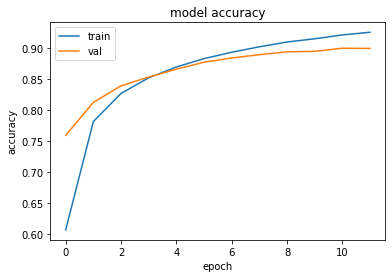

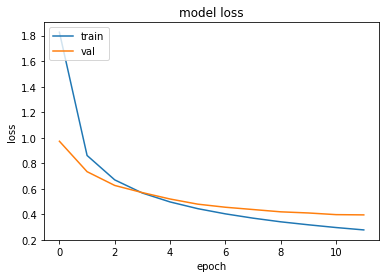

In [31]:
import keras
from matplotlib import pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [106]:
precision_recall_fscore_support(y_test, predictions, average="weighted")

(0.8973216160687406, 0.8947302904564315, 0.8929054162681139, None)

# Fasttetx using faiss

In [49]:
pip install faiss-cpu

     |████████████████████████████████| 8.5 MB 19.0 MB/s            
Note: you may need to restart the kernel to use updated packages.


In [50]:
import faiss
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

In [51]:
def get_n_similar_materials(features, k=50):
    
    index = faiss.IndexFlatIP(features.shape[1])
    faiss.normalize_L2(features)
    index.add(features)

    distances, neighbours = index.search(features, k)
    
    return distances, neighbours

In [52]:
index = faiss.IndexFlatIP(train_vector.shape[1])
faiss.normalize_L2(train_vector)
index.add(train_vector)
faiss.write_index(index, "faiss_index.pkl")

In [53]:
model_dict = {}
for kNN in [1]:
    faiss.normalize_L2(test_vector)
    nearest_neighbours = index.search(test_vector, kNN)
    predictions = [train.iloc[neighbour].CATEGORY_ID.value_counts().index[0] for neighbour in nearest_neighbours[1]]
    test["pred"] = predictions
    print(precision_recall_fscore_support(test.CATEGORY_ID, test.pred, average="weighted")[2])

0.8803615327749309


In [54]:
predictions = [train.iloc[neighbour].CATEGORY_ID.value_counts().index[0] for neighbour in nearest_neighbours[1]]

In [75]:
test["PRED_ID"] = predictions

In [76]:
pred_path_list = []
for i in test["PRED_ID"]:
    pred_path_list.append(" > ".join(category_dict[i]))
    
test["PRED_PATH"] = pred_path_list

In [77]:
test[["MATERIAL_ID","NAME_BRIEF",
      "NAME_DESCRIPTION","CATEGORY_ID",
      "PRED_ID","CATEGORY_PATH","PRED_PATH"]].to_csv("test_faiss_CNN.csv",index=False)